# Project 9: Image Inpainting using GAN: An Investigation of Spectral Normalization and Perceptual Loss with Limited Dataset Resolution.

- #### Minglei               &nbsp;                Li    &nbsp;&nbsp;&nbsp;&nbsp;       m483li@uwaterloo.ca

## 1. Abstract
#### The goal of this project is to implement and evaluate an image inpainting method on a lower resolution image dataset. The proposed method, Aggregated Contextual-Transformation GAN (AOT-GAN), addresses the challenges of image content reasoning from distant contexts and fine-grained texture synthesis for large missing regions. The generator of AOT-GAN is constructed by stacking multiple layers of a proposed AOT block that aggregates contextual transformations from various receptive fields, allowing to capture both informative distant image contexts and rich patterns of interest. The discriminator of AOT-GAN is enhanced by training it with a tailored mask-prediction task to distinguish the detailed appearances of real and synthesized patches, facilitating the generator to synthesize clear textures.
#### To achieve this goal, we have utilized the codebase and models provided by the authors of the AOT-GAN paper available on their GitHub repository. We have trained an AOT-GAN model on our dataset, which consists of lower resolution images due to hardware limitations. Additionally, we will perform qualitative evaluation through visual inspection and user studies. Our testing code runs efficiently on a CPU in a short amount of time.
#### Note: We trained for 50 epochs using an A100 GPU, which took approximately 25 hours. However, if the GPU memory is less than 30GB, it may not be able to complete the training.

Reference of the paper: https://arxiv.org/pdf/2104.01431.pdf

## 2. Contributions
- #### Yao Li (y2985li@uwaterloo.ca): Contributed to the literature review, model implementation, and evaluation of results, trained the model, and helped in writing the final report.
- #### Minglei Li (m483li@uwaterloo.ca): Conducted experiments to optimize hyperparameters, implemented the testing code and loss functions, and helped in writing the final report.
- #### Zeyu Niu (z8niu@uwaterloo.ca): Helped in data preprocessing, provided valuable feedback on the model architecture,trained the model, provided own libraries, and helped in writing the final report.
#### Note: All team members collaborated on designing the project, discussing results, and troubleshooting.

## 3. Code Libraries

This project relies on several external code libraries and our own custom libraries to provide essential functionality. Below, we provide a summary of each library, their importance to the project, and installation instructions if they are not part of the default Anaconda package.

In [1]:
### External Libraries
# Import necessary libraries

# This built-in library is used for handling file and directory 
# paths and interacting with the operating system.
import os
# provides support for arrays and a wide variety of mathematical functions.
# It is essential for handling data and performing mathematical operations in our project.
# Used in our custom lib utils.py to make masks for the images
# Installation: `pip install numpy`
import numpy as np
# For generating random numbers
# Used in our custom lib utils.py to generate random mask size and location
import random

# Import PyTorch libraries
# A popular open-source deep learning framework
# Used for building and training neural networks in our project.
# Installation: `pip install torch torchvision torchaudio`
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.functional import conv2d
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image # Saving images to disk
# Import DataLoader and Dataset for handling data
from torch.utils.data import DataLoader, Dataset 

# Used for image processing in this project
# Installation: `pip install pillow`
from PIL import Image
# Import matplotlib for visualization
# Installation: `pip install matplotlib`
import matplotlib.pyplot as plt

# Used in our custom lib celeba.py
# Used to download dataset from the google drive
# Installation: `pip install gdown`
import gdown
# Used to unzip the dataset downloaded from the google drive
import zipfile

### Custom Libraries

# import our own code library
# `create_mask` will be used to create random mask for each image
# a random size (between 1/5 and 2/5 of original image size) rectangle
#   mask at random location
# note that the mask region has the value 1, and 0 for non-mask region
from mylibs.utils import create_mask
# `postprocess` processes the image tensor to convert it into an image that can be
# saved to disk. It clamps the tensor values, scales them to the range [0, 255], and
# converts the tensor to a NumPy array.
# check mylibs/utils.py for detailed information and implementation
from mylibs.utils import postprocess
# This library help download the CelebA 512x512 dataset from the google drive
# and then spilt them into training and testing dataset
# you should have structure like this after runing this function:
# datasets/
# │
# ├── train/
# │   ├── image132.png
# │   ├── image22.png
# │   └── ...
# │   
# ├── test/
# │   ├── image27240.png
# │   ├── image29001.png
# │   └── ...
from mylibs.celeba import download_celeba_dataset

# These custom libraries can be found in the mylibs subdirectory of the project,
# with the corresponding .py files.

In [2]:
# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this line is used when training on A100 for debuging
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## 4. Dataset

Using CelebA 512x512 images to train our models due to limited computing resources

In [3]:
class Dataset(Dataset):
    def __init__(self, root_dir, img_transform=None, mask_transform=None, train=True):
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.train = train
        
        if self.train:
            # training dataset
            self.root_dir = f'{root_dir}/train'
            self.image_paths = list(os.listdir(self.root_dir))
            self.image_paths = [os.path.join(self.root_dir, file) for file in self.image_paths]
        else:
            # testing dataset
            self.root_dir = f'{root_dir}/test'
            self.image_paths = list(os.listdir(self.root_dir))
            self.image_paths = [os.path.join(self.root_dir, file) for file in self.image_paths]

    def __len__(self):
        # Return the total number of samples in your dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Return the image and its corresponding mask
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # Create a binary mask with a random hole
        # using a random size (between 1/5 and 2/5 of original image size)
        #   rectangle mask at random location
        # note that the mask region has the value 1, and 0 for non-mask
        mask = create_mask(image)

        # transform the image and mask
        if self.train:
            image = self.img_transform(image) * 2. - 1.
            mask = self.mask_transform(mask)
        else:
            # to better visualize the image, no transform
            image = transforms.ToTensor()(image)
            mask = self.mask_transform(mask)

        return image, mask

### Prepare the training and testing data

Our own code library celeba.py will help download and prepare the CelebA 512x512 images. Run the cell below to download the dataset and spilt them into training and testing dataset (Only need to run it once).

** Note that 'gdown' is required to download the dataset from the google drive (pip install gdown).

You can also manually download the dataset from https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P

In [4]:
# the directory name that contains the dataset, feel free to change it
DATASET_PATH = 'datasets' 

In [ ]:
# ONLY run this cell once
# no need to run this cell if you already have the datasets

# prepare the Celeba dataset, the datasets will be downloaded from google drive
download_celeba_dataset(root=DATASET_PATH)

In [7]:
# Set image size for resizing
# note the training data used to train the model have image size 512x512
img_size = (512, 512)
# Define image transformations
img_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.05, 0.05, 0.05, 0.05), # Apply random color jitter
    transforms.ToTensor()
])
# Define mask transformations
mask_transform = transforms.Compose([
    transforms.Resize(img_size),
    # Apply random rotation for the mask
    transforms.RandomRotation((0, 45), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Create train and test datasets using the custom Dataset class above
train_dataset = Dataset(root_dir=DATASET_PATH, img_transform=img_transform,
                        mask_transform=mask_transform, train=True)
test_dataset = Dataset(root_dir=DATASET_PATH, img_transform=img_transform,
                       mask_transform=mask_transform, train=False)

# Create DataLoaders for train and test datasets
# batch size of 8 is used due to limited computing resource (recommend for GPU RAM < 32GB)
train_dataloader = DataLoader(train_dataset, batch_size=8,
                              shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=8,
                             shuffle=False, num_workers=2)

## 5. Model
![My image](./images/demo/1.png)
<center>Figure 1. (From the paper)</center>

The Aggregated COntextual-Transformation GAN (AOT-GAN) is a generative adversarial network that consists of a generator and a discriminator. The generator is made up of multiple layers of a specialized block called the AOT block, which enhances context reasoning. The discriminator is trained to predict downsampled patch-level inpainting masks. The model is optimized by a reconstruction loss, an adversarial loss, a perceptual loss, and a style loss. The overall goal is to create high-quality inpainted images that are both visually appealing and accurate in terms of pixel-level reconstruction.

![My image](./images/demo/2.png)
<center>Figure 2. (From the paper)</center>

The AOT (Adaptive Orderless Texture) block is a novel type of convolutional block introduced in the paper "AOT-GAN: Adaptive-Orderless Texture Synthesis from a Single Example" by Zhang et al. It is designed to synthesize textures that are adaptive to input masks, while being able to capture orderless features of textures.

The AOT block consists of several dilated convolutional layers with different dilation rates, which allows it to capture features at different scales. Specifically, each AOT block in the generator consists of several dilated convolutional layers with increasing dilation rates, followed by a fusion layer that combines the output of all dilated convolutional layers, and a gate layer that produces a mask indicating which features to keep and which to discard.

Compared to the traditional residual block, the AOT block has several advantages in synthesizing adaptive textures. First, the use of dilated convolutional layers with increasing dilation rates enables the AOT block to capture features at different scales and effectively enlarge the receptive field of the network. Second, the fusion layer in the AOT block allows it to combine features extracted at different scales in a flexible way, which is important for synthesizing adaptive textures that can change smoothly over space. Third, the gate layer in the AOT block provides a mechanism to adaptively select features based on input masks, which enables the network to synthesize textures that are consistent with the input masks.

Overall, the AOT block is a powerful tool for synthesizing adaptive textures and can be used in various generative models beyond the AOT-GAN, such as image inpainting, super-resolution, and style transfer.

#### The Generator class has three main components: the encoder, the middle, and the decoder. The encoder takes an input image concatenated with the mask and processes it through a series of convolutional layers. The middle part contains a sequence of AOTBlocks, which are responsible for the adaptive texture synthesis. The decoder then reconstructs the image through a series of up-convolutional layers.

In [8]:
# Generator class for AOT-GAN
class Generator(nn.Module):
    def __init__(self, rates=[1,2,4,8], block_num=8):  # 1046
        super(Generator, self).__init__()

        # Encoder: Takes input image concatenated with mask
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(4, 64, 7),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(True)
        )

        # Middle part: Sequence of AOTBlocks for adaptive texture synthesis
        self.middle = nn.Sequential(*[AOTBlock(256, rates) for _ in range(block_num)])

        # Decoder: Reconstructs the image using up-convolutional layers
        self.decoder = nn.Sequential(
            UpConv(256, 128),
            nn.ReLU(True),
            UpConv(128, 64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1)
        )

    def forward(self, x, mask):
        x = torch.cat([x, mask], dim=1)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = torch.tanh(x)
        return x

#### The UpConv class is a helper module for implementing up-convolution operations in the decoder part of the generator. It upsamples the input features using bilinear interpolation and applies a convolution operation on the upsampled feature map.

In [9]:
# UpConv: Helper module for implementing up-convolutions in the decoder
class UpConv(nn.Module):
    def __init__(self, inc, outc, scale=2):
        super(UpConv, self).__init__()
        self.scale = scale
        self.conv = nn.Conv2d(inc, outc, 3, stride=1, padding=1)

    def forward(self, x):
        return self.conv(nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True))

#### The my_layer_norm function is a custom layer normalization implementation that normalizes the input features across the spatial dimensions, which is used in the AOTBlock's gate layer.
#### The AOTBlock class represents the novel AOT block introduced in the paper. It comprises several dilated convolutional layers with different dilation rates, a fusion layer, and a gate layer. The AOT block is designed to capture orderless features of textures and adaptively synthesize textures based on input masks.

In [10]:
# Custom layer normalization implementation
def my_layer_norm(feat):
    mean = feat.mean((2, 3), keepdim=True)
    std = feat.std((2, 3), keepdim=True) + 1e-9
    feat = 2 * (feat - mean) / std - 1
    feat = 5 * feat
    return feat

# AOTBlock: Represents the novel AOT block introduced in the paper
# Captures orderless features of textures and adaptively synthesizes textures based on input masks
class AOTBlock(nn.Module):
    def __init__(self, dim, rates):
        super(AOTBlock, self).__init__()
        self.rates = rates
        for i, rate in enumerate(rates):
            self.__setattr__(
                'block{}'.format(str(i).zfill(2)), 
                nn.Sequential(
                    nn.ReflectionPad2d(rate),
                    nn.Conv2d(dim, dim//4, 3, padding=0, dilation=rate),
                    nn.ReLU(True)))
        self.fuse = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, padding=0, dilation=1))
        self.gate = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, padding=0, dilation=1))

    def forward(self, x):
        out = [self.__getattr__(f'block{str(i).zfill(2)}')(x) for i in range(len(self.rates))]
        out = torch.cat(out, 1)
        out = self.fuse(out)
        mask = my_layer_norm(self.gate(x))
        mask = torch.sigmoid(mask)
        return x * (1 - mask) + out * mask

#### Lastly, the Discriminator class implements a discriminator network with a series of convolutional layers, including spectral normalization and leaky ReLU activation functions. The discriminator is designed to predict downsampled patch-level inpainting masks.

In [11]:
# ----- discriminator -----
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        inc = 3
        # Convolutional layers with spectral normalization and leaky ReLU activation functions
        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(inc, 64, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, stride=1, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        # Predicts downsampled patch-level inpainting masks
        feat = self.conv(x)
        return feat

## 6. Loss

The principle of choosing optimization objectives for image in-painting is to ensure both per-pixel reconstruction accuracy and visual fidelity of inpainted images. To this end, we carefully select four optimization objectives, i.e., a **L1 loss**, a **style loss**, a **perceptual loss**, and an **adversarial loss** of the proposed **SM-PatchGAN**, for AOT-GAN following the majority of existing deep inpainting models.

### L1 Loss
First, we include a L1 loss to ensure the reconstruction accuracy on pixel-level:
$$L_{rec} =\left \| x-G(x\odot(1-m),m) \right \|_1$$

L1 loss is a type of loss function that computes the absolute difference between the predicted and true values. It is also known as Mean Absolute Error (MAE) or L1-norm loss. In the given code, the L1 loss is calculated using the PyTorch's nn.L1Loss() function. It is a common loss function used for regression problems or when pixel-wise differences are important.

In [12]:
class L1(): 
    def __init__(self,):
        self.calc = torch.nn.L1Loss()
    
    def __call__(self, x, y):
        return self.calc(x, y)

### VGG19
We use VGG19 pretrained on ImageNet as our pre-trained network for calculating the style loss and the perceptual loss.
This class defines a custom VGG19 model for feature extraction. It loads the pre-trained VGG19 model from torchvision.models and extracts features at specific ReLU layers. The forward method processes the input image by resizing and normalizing it before passing it through the ReLU layers. The output is a dictionary containing features from the specified ReLU layers.

In [13]:
class VGG19(nn.Module):
    # Initializes the custom VGG19 model by loading the pre-trained VGG19 model 
    # and extracting its features. It creates new ReLU layers and adds the corresponding VGG19 layers to them. It also sets the mean and standard deviation values required for input normalization.
    def __init__(self, resize_input=False):
        super(VGG19, self).__init__()
        features = models.vgg19(pretrained=True).features

        self.resize_input = resize_input
        self.mean = torch.Tensor([0.485, 0.456, 0.406]).to(device)
        self.std = torch.Tensor([0.229, 0.224, 0.225]).to(device)
        prefix = [1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
        posfix = [1, 2, 1, 2, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
        names = list(zip(prefix, posfix))
        self.relus = []
        for pre, pos in names:
            self.relus.append('relu{}_{}'.format(pre, pos))
            self.__setattr__('relu{}_{}'.format(
                pre, pos), torch.nn.Sequential())

        nums = [[0, 1], [2, 3], [4, 5, 6], [7, 8],
                [9, 10, 11], [12, 13], [14, 15], [16, 17],
                [18, 19, 20], [21, 22], [23, 24], [25, 26],
                [27, 28, 29], [30, 31], [32, 33], [34, 35]]

        for i, layer in enumerate(self.relus):
            for num in nums[i]:
                self.__getattr__(layer).add_module(str(num), features[num])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # resize and normalize input for pretrained vgg19
        x = (x + 1.0) / 2.0
        x = (x - self.mean.view(1, 3, 1, 1)) / (self.std.view(1, 3, 1, 1))
        if self.resize_input:
            x = F.interpolate(
                x, size=(256, 256), mode='bilinear', align_corners=True)
        features = []
        for layer in self.relus:
            x = self.__getattr__(layer)(x)
            features.append(x)
        out = {key: value for (key, value) in list(zip(self.relus, features))}
        return out


### Perceptual Loss
Since the effectiveness of the perceptual loss and the style loss for image inpainting have been widely verified , we include them to improve the accuracy of perceptual reconstruction. Specifically, a perceptual loss aims at minimizing the L1 distance between the activation maps of inpainted and real images:
$$L_{per} = \sum_i \frac{\left \| \phi_i(x) - \phi_i(z) \right \|_1}{N_i}$$
where $\phi_i$ is the activation map from the $i$-th layers of a pre-trained network (e.g., VGG19), $N_i$ is the number of elements in $\phi_i$.

Perceptual loss measures the perceptual difference between two images. It is particularly useful for image generation tasks, as it helps maintain high-frequency details in the generated images. The following code implements perceptual loss using the pre-trained VGG19 network. The VGG19 features are computed for both input and target images, and the L1 loss is calculated between their corresponding feature maps with a weighted sum.

In [14]:
class Perceptual(nn.Module):
    def __init__(self, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super(Perceptual, self).__init__()
        self.vgg = VGG19().to(device)
        self.criterion = torch.nn.L1Loss()
        self.weights = weights

    def __call__(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        content_loss = 0.0
        prefix = [1, 2, 3, 4, 5]
        for i in range(5):
            content_loss += self.weights[i] * self.criterion(
                x_vgg[f'relu{prefix[i]}_1'], y_vgg[f'relu{prefix[i]}_1'])
        return content_loss

### Style Loss

Similarly, the Style loss is defined as the L1 distance between the Gram matrices of deep features of inpainted and real images:
$$L_{sty} = \sum_i \left \| \phi_i(x)^T \phi_i(x) - \phi_i(z)^T \phi_i(z) \right \|_1$$

Style loss is used to capture the style information of an image. It is commonly employed in style transfer tasks. The given code uses the Gram matrix, a representation that captures the correlation between feature maps, to compute the style loss. The VGG19 features are computed for both input and target images, and the L1 loss is calculated between their corresponding Gram matrices.

In [16]:
class Style(nn.Module):
    def __init__(self):
        super(Style, self).__init__()
        self.vgg = VGG19().to(device)
        self.criterion = torch.nn.L1Loss()

    def compute_gram(self, x):
        b, c, h, w = x.size()
        f = x.view(b, c, w * h)
        f_T = f.transpose(1, 2)
        G = f.bmm(f_T) / (h * w * c)
        return G

    def __call__(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        style_loss = 0.0
        prefix = [2, 3, 4, 5]
        posfix = [2, 4, 4, 2]
        for pre, pos in list(zip(prefix, posfix)):
            style_loss += self.criterion(
                self.compute_gram(x_vgg[f'relu{pre}_{pos}']), self.compute_gram(y_vgg[f'relu{pre}_{pos}']))
        return style_loss

### Smgan Loss
The Soft Mask-guided PatchGAN (SM-PatchGAN) loss is a novel mask-prediction technique for enhancing the training of the discriminator in AOT-GAN, facilitating the synthesis of clear textures in high-resolution image inpainting tasks. By incorporating a mask-prediction task, SM-PatchGAN guides the discriminator to better distinguish between real and inpainted image patches, resulting in improved fine-grained texture generation. In following code, the discriminator's output for both fake and real images is resized to match the size of the masks, and a soft mask is created by applying Gaussian blur to the binary inpainting masks. The loss is computed using the MSE loss function for both the discriminator and the generator, incorporating the soft mask to guide the learning process. The mean of the computed losses is returned as the final output.

In the case of Gaussian filtering within the SM-PatchGAN, a Gaussian kernel with a 70x70 size is utilized to simulate pixel propagation through the discriminator network's convolutions. Importantly, to prevent color shift issues arising from normalization layers, we eliminate all normalization layers in the generator network.

In [17]:
def gaussian(window_size, sigma):
    def gauss_fcn(x):
        return -(x - window_size // 2)**2 / float(2 * sigma**2)
    gauss = torch.stack([torch.exp(torch.tensor(gauss_fcn(x)))
                         for x in range(window_size)])
    return gauss / gauss.sum()


def get_gaussian_kernel(kernel_size: int, sigma: float) -> torch.Tensor:
    if not isinstance(kernel_size, int) or kernel_size % 2 == 0 or kernel_size <= 0:
        raise TypeError(
            "kernel_size must be an odd positive integer. Got {}".format(kernel_size))
    window_1d: torch.Tensor = gaussian(kernel_size, sigma)
    return window_1d


def get_gaussian_kernel2d(kernel_size, sigma):
    if not isinstance(kernel_size, tuple) or len(kernel_size) != 2:
        raise TypeError(
            "kernel_size must be a tuple of length two. Got {}".format(kernel_size))
    if not isinstance(sigma, tuple) or len(sigma) != 2:
        raise TypeError(
            "sigma must be a tuple of length two. Got {}".format(sigma))
    ksize_x, ksize_y = kernel_size
    sigma_x, sigma_y = sigma
    kernel_x: torch.Tensor = get_gaussian_kernel(ksize_x, sigma_x)
    kernel_y: torch.Tensor = get_gaussian_kernel(ksize_y, sigma_y)
    kernel_2d: torch.Tensor = torch.matmul(
        kernel_x.unsqueeze(-1), kernel_y.unsqueeze(-1).t())
    return kernel_2d


class GaussianBlur(nn.Module):

    def __init__(self, kernel_size, sigma):
        super(GaussianBlur, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self._padding = self.compute_zero_padding(kernel_size)
        self.kernel = get_gaussian_kernel2d(kernel_size, sigma)

    @staticmethod
    def compute_zero_padding(kernel_size):
        """Computes zero padding tuple."""
        computed = [(k - 1) // 2 for k in kernel_size]
        return computed[0], computed[1]

    def forward(self, x):
        if not torch.is_tensor(x):
            raise TypeError(
                "Input x type is not a torch.Tensor. Got {}".format(type(x)))
        if not len(x.shape) == 4:
            raise ValueError(
                "Invalid input shape, we expect BxCxHxW. Got: {}".format(x.shape))
        # prepare kernel
        b, c, h, w = x.shape
        tmp_kernel: torch.Tensor = self.kernel.to(x.device).to(x.dtype)
        kernel: torch.Tensor = tmp_kernel.repeat(c, 1, 1, 1)

        return conv2d(x, kernel, padding=self._padding, stride=1, groups=c)


def gaussian_blur(input, kernel_size, sigma):
    return GaussianBlur(kernel_size, sigma)(input)


class Smgan():
    def __init__(self, ksize=71): 
        self.ksize = ksize
        self.loss_fn = nn.MSELoss()
    
    def __call__(self, netD, fake, real, masks): 
        fake_detach = fake.detach()

        g_fake = netD(fake)
        d_fake  = netD(fake_detach)
        d_real = netD(real)

        _, _, h, w = g_fake.size()
        b, c, ht, wt = masks.size()
        
        # Handle inconsistent size between outputs and masks
        if h != ht or w != wt:
            g_fake = F.interpolate(g_fake, size=(ht, wt), mode='bilinear', align_corners=True)
            d_fake = F.interpolate(d_fake, size=(ht, wt), mode='bilinear', align_corners=True)
            d_real = F.interpolate(d_real, size=(ht, wt), mode='bilinear', align_corners=True)
        d_fake_label = gaussian_blur(masks, (self.ksize, self.ksize), (10, 10)).detach().to(device)
        d_real_label = torch.zeros_like(d_real).to(device)
        g_fake_label = torch.ones_like(g_fake).to(device)

        dis_loss = self.loss_fn(d_fake, d_fake_label) + self.loss_fn(d_real, d_real_label)
        gen_loss = self.loss_fn(g_fake, g_fake_label) * masks / torch.mean(masks)

        return dis_loss.mean(), gen_loss.mean()

### Initialize Loss Functions

In [18]:
l1 = L1()
style = Style()
perceptual = Perceptual()
smgan = Smgan()

/Users/frank/miniforge3/envs/py3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/frank/miniforge3/envs/py3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 7. Train and Evaluate

### Train Function

Finally, we include the adversarial loss of SM-PatchGAN described in Eq. 4 to improve the visual fidelity of inpainted images. The whole AOT-GAN is trained by a joint optimization of these four objectives, and we conclude the overall optimization objective as below:
$$L = \lambda_{adv} L^G_{adv} + \lambda_{rec} L_{rec} + \lambda_{per} L_{per} + \lambda_{sty} L_{sty}$$
For our experiments, we empirically choose $λ_{adv} = 0.01$, $λ_{rec} = 1$, $λ_{per} = 0.1$ and λ_{sty} = 250 for training.

In [19]:
def train(epoch, generator, gen_optimizer, discriminator, dis_optimizer):
    """
    This function trains the generator and discriminator networks for one epoch.
    It calculates and accumulates the generator and discriminator losses, and performs
    the optimization steps for each network.

    Args:
        epoch (int): Current epoch number.
        generator (Generator): Generator network.
        gen_optimizer (torch.optim.Optimizer): Optimizer for the generator.
        discriminator (Discriminator): Discriminator network.
        dis_optimizer (torch.optim.Optimizer): Optimizer for the discriminator.

    Returns:
        tuple: A tuple containing average generator loss, average discriminator loss,
               average L1 loss, average style loss, and average perceptual loss.
    """
    # Initialize loss accumulators
    all_dis_loss = 0
    all_gen_loss = 0
    all_l1_loss = 0
    all_style_loss = 0
    all_perceptual_loss = 0
     # Set the networks to training mode
    generator.train()
    discriminator.train()

    # Iterate over the training data
    for i, (images, masks) in enumerate(train_dataloader):
        # Move images and masks to the device (GPU or CPU)
        real_images = images.to(device)
        real_masks = masks.to(device)
        # Apply masks to the images
        masked_images = real_images * (1 - real_masks).float() + real_masks

        # Generate fake images using the generator
        fake_images = generator(masked_images, real_masks)
        # Create completed images by blending real and fake images using the masks
        completed_images = real_images * (1 - real_masks) + fake_images * real_masks

        # Calculate losses
        losses = {}
        losses["L1"] = 1 * l1(fake_images, real_images)
        losses["Style"] = 250 * style(fake_images, real_images)
        losses["Perceptual"] = 0.1 * perceptual(fake_images, real_images)
        # Calculate discriminator and generator losses using SMGAN
        dis_loss, gen_loss = smgan(discriminator, completed_images,
                                           real_images, real_masks)
        losses["advg"] = gen_loss * 0.01

        # Perform backpropagation and optimization
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        sum(losses.values()).backward()
        # Accumulate generator losses
        all_gen_loss += gen_loss
        all_l1_loss += losses["L1"]
        all_style_loss += losses["Style"]
        all_perceptual_loss += losses["Perceptual"]
        # Update the discriminator loss and perform backpropagati
        losses["advd"] = dis_loss
        dis_loss.backward()
        # Update the optimizer
        gen_optimizer.step()
        dis_optimizer.step()
        # Accumulate discriminator loss
        all_dis_loss += dis_loss

        if i % 100 == 0:
            # Print progress every 100 iterations
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tGLoss: {:.6f} DLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_dataloader.dataset),
                100. * i / len(train_dataloader),
                sum(losses.values()) / len(images), dis_loss.item() / len(images)))
            
    # Calculate  and return average losses
    avg_dis_loss = all_dis_loss / len(train_dataloader.dataset)
    avg_gen_loss = all_gen_loss / len(train_dataloader.dataset)
    avg_l1_loss = all_l1_loss / len(train_dataloader.dataset)
    avg_style_loss = all_style_loss / len(train_dataloader.dataset)
    avg_perceptual_loss = all_perceptual_loss / len(train_dataloader.dataset)
    print('====> Epoch: {} Average GLoss: {:.4f} Average DLoss: {:.4f}'.format(
          epoch, avg_gen_loss, avg_dis_loss))
    
    return avg_gen_loss, avg_dis_loss, avg_l1_loss, avg_style_loss, avg_perceptual_loss

### Evaluate Function

In [20]:
def evaluate(epoch, generator, discriminator):
    """
    This function evaluates the generator and discriminator networks on the test dataset.
    It calculates and accumulates the generator and discriminator losses without
    updating the network parameters.

    Args:
        epoch (int): Current epoch number.
        generator (Generator): Generator network.
        discriminator (Discriminator): Discriminator network.

    Returns:
        tuple: A tuple containing average generator loss, average discriminator loss,
               average L1 loss, average style loss, and average perceptual loss.
    """
    # Initialize loss accumulators
    all_dis_loss = 0
    all_gen_loss = 0
    all_l1_loss = 0
    all_style_loss = 0
    all_perceptual_loss = 0
    # Set the networks to evaluation mode
    generator.eval()
    discriminator.eval()

    # Disable gradient computation
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_dataloader):
            # Move images and masks to the device (GPU or CPU)
            real_images = images.to(device)
            real_masks = masks.to(device)
            # Apply masks to the images
            masked_images = real_images * (1 - real_masks).float() + real_masks

            # Generate fake images using the generator
            fake_images = generator(masked_images, real_masks)
            # Create completed images by blending real and fake images using the masks
            completed_images = real_images * (1 - real_masks) + fake_images * real_masks

            # Calculate losses
            losses = {}
            losses["L1"] = 1 * l1(fake_images, real_images)
            losses["Style"] = 250 * style(fake_images, real_images)
            losses["Perceptual"] = 0.1 * perceptual(fake_images, real_images)
            # Calculate discriminator and generator losses using SMGAN
            dis_loss, gen_loss = smgan(discriminator, completed_images,
                                              real_images, real_masks)
            losses["advg"] = gen_loss * 0.01

            # Accumulate losses 
            all_gen_loss += gen_loss
            all_l1_loss += losses["L1"]
            all_style_loss += losses["Style"]
            all_perceptual_loss += losses["Perceptual"]
            all_dis_loss += dis_loss
            
    # Calculate and return average losses
    avg_dis_loss = all_dis_loss / len(test_dataloader.dataset)
    avg_gen_loss = all_gen_loss / len(test_dataloader.dataset)
    avg_l1_loss = all_l1_loss / len(test_dataloader.dataset)
    avg_style_loss = all_style_loss / len(test_dataloader.dataset)
    avg_perceptual_loss = all_perceptual_loss / len(test_dataloader.dataset)
    print('====> Test set Gloss: {:.4f}   Dloss: {:.4f}'.format(avg_gen_loss, avg_dis_loss))
    
    return avg_gen_loss, avg_dis_loss, avg_l1_loss, avg_style_loss, avg_perceptual_loss

### Train the Model

During the model training process, each mini-batch consists of eight images that are randomly selected, along with their corresponding masks, which are also randomly generated. Both the discriminator and generator are trained using a consistent learning rate of 1e-4. The Adam optimizer is employed for training, with β1 set to 0.5 and β2 set to 0.999.

In [ ]:
# this is the cell used to train the generator and the discriminator
# due to the limited computing resources, we trained our model on different machines.
# For each machine, we might have different number of epoch trained, the trained model is 
# saved after each phase and losses are also stored. The final version of the models
# and losses after each epoch are included in this zip file
# To train the models, at least 32GB GPU RAM is recommended (others might encounter run out of gpu memory error)

# Initialize the model
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Since our training process has servel phases due to limited computing resources
# each phase starts with the trained model from the previous phase
# generator.load_state_dict(torch.load("./generator_epoch_pretrained_40.pt", map_location=device))
# discriminator.load_state_dict(torch.load("./discriminator_epoch_pretrained_40.pt", map_location=device))

# Initialize the optimizer
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# the number of epoch we decided to train at this phase
num_epochs = 10

# Initialize lists to store average losses for training and testing
# store the caculated losses data so we can visualize the entire training and testing losses
#   at the end
dis_avg_train_losses = []
dis_avg_test_losses = []
gen_avg_train_losses = []
gen_avg_test_losses = []

avg_l1_train_losses = []
avg_style_train_losses = []
avg_perceptual_train_losses = []
avg_l1_test_losses = []
avg_style_test_losses = []
avg_perceptual_test_losses = []

# Train and evaluate the model for the specified number of epochs at this phase
for epoch in range(40, 40+num_epochs):
    # Train the model
    gen_avg_train_loss, dis_avg_train_loss, avg_l1_train_loss, avg_style_train_loss, avg_perceptual_train_loss = train(epoch, generator, gen_optimizer,
                                                   discriminator, dis_optimizer)
    # Store the average training losses for this epoch
    dis_avg_train_losses.append(dis_avg_train_loss)
    gen_avg_train_losses.append(gen_avg_train_loss)
    avg_l1_train_losses.append(avg_l1_train_loss)
    avg_style_train_losses.append(avg_style_train_loss)
    avg_perceptual_train_losses.append(avg_perceptual_train_loss)

    # Evaluate the model on the test dataset
    gen_avg_test_loss, dis_avg_test_loss, avg_l1_test_loss, avg_style_test_loss, avg_perceptual_test_loss = evaluate(epoch, generator, discriminator)
    # Store the average testing losses for this epoch
    dis_avg_test_losses.append(dis_avg_test_loss)
    gen_avg_test_losses.append(gen_avg_test_loss)
    avg_l1_test_losses.append(avg_l1_test_loss)
    avg_style_test_losses.append(avg_style_test_loss)
    avg_perceptual_test_losses.append(avg_perceptual_test_loss)
    # Generate images for visualization of the result of the generator
    with torch.no_grad():
        images, masks = next(iter(test_dataloader))
        real_images = images.to(device)
        real_masks = masks.to(device)
        # get the image and mask for image inpainting
        real_images, real_masks = real_images[1], real_masks[1]

        # mask the image
        image = (real_images * 2.0 - 1.0).unsqueeze(0)
        mask = real_masks.unsqueeze(0)
        image_masked = image * (1 - mask.float()) + mask
        # inpainting the image
        pred_img = generator(image_masked, mask)
        comp_imgs = (1 - mask) * image + mask * pred_img
        
        # save the result images to visualize the training process
        if not os.path.exists('results'):
          os.mkdir('results')
        postprocess(image[0]).save(os.path.join('./results', f'img_{epoch+1}.png'))
        postprocess(image_masked[0]).save(os.path.join('./results', f'img_masked_{epoch+1}.png'))
        postprocess(comp_imgs[0]).save(os.path.join('./results', f'img_comp_{epoch+1}.png'))

    # Save the generator and discriminator models at the end of each epoch
    if not os.path.exists('models'):
        os.mkdir('models')
    torch.save(generator.state_dict(), f'./models/generator_epoch_{epoch+1}.pt')
    torch.save(discriminator.state_dict(), f'./models/discriminator_epoch_{epoch+1}.pt')

# Save losses
with open("./losses/g_train_loss.txt", "w") as file:
    for item in gen_avg_train_losses:
        file.write(str(item) + "\n")
with open("./losses/g_test_loss.txt", "w") as file:
    for item in gen_avg_test_losses:
        file.write(str(item) + "\n")
with open("./losses/d_train_loss.txt", "w") as file:
    for item in dis_avg_train_losses:
        file.write(str(item) + "\n")
with open("./losses/d_test_loss.txt", "w") as file:
    for item in gen_avg_test_losses:
        file.write(str(item) + "\n")

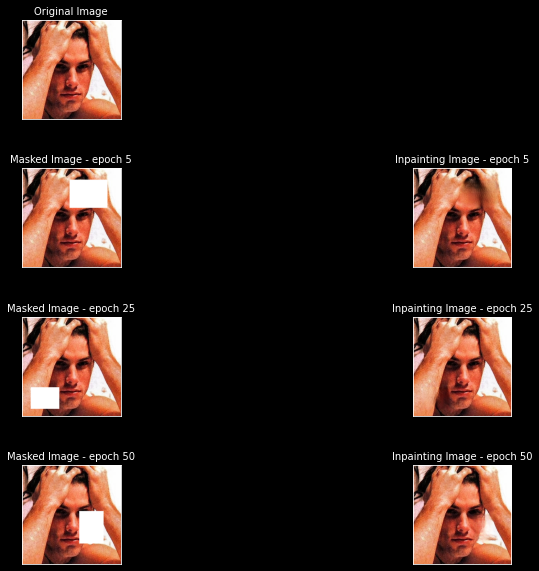

In [21]:
# this cell demonstrates the training effect changing during each epoch. Since
# our training involves multiple phases, we cannot display the entire training 
# process at once, so the results after different epoch are stored and displayed here

# read the image files from the test directory
image_dir = './images/eval/'
original_img_path = image_dir + 'img.png'
masked_paths = [
    image_dir + 'img_masked_5.png',
    image_dir + 'img_masked_25.png',
    image_dir + 'img_masked_50.png'
]
inpaint_paths = [
    image_dir + 'img_comp_5.png',
    image_dir + 'img_comp_25.png',
    image_dir + 'img_comp_50.png'
]

fig = plt.figure(figsize=(14, 10))
title_size = 10  # Adjust this value to change the title size
# the results after epoch 5, 25, 50 are chose to be displayed
epochs = [5, 25, 50]

# Display the original image
ax1 = fig.add_subplot(4, 2, 1)
plt.title('Original Image', fontsize=title_size)
original_image = Image.open(original_img_path)
ax1.imshow(original_image)

# Display the masked and inpainted images at different epochs
for i, (masked_path, inpaint_path, epoch) in enumerate(zip(masked_paths, inpaint_paths, epochs)):
    masked_image = Image.open(masked_path)
    inpaint_image = Image.open(inpaint_path)

    ax_masked = fig.add_subplot(4, 2, 2 * i + 3)
    plt.title(f'Masked Image - epoch {epoch}', fontsize=title_size)
    ax_masked.imshow(masked_image)

    ax_inpaint = fig.add_subplot(4, 2, 2 * i + 4)
    plt.title(f'Inpainting Image - epoch {epoch}', fontsize=title_size)
    ax_inpaint.imshow(inpaint_image)

# Remove axis ticks for a cleaner display
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust these values to change column and row distance
plt.subplots_adjust(wspace=0.001, hspace=0.5)
plt.show()

### Display the Loss

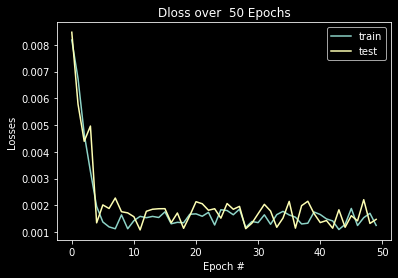

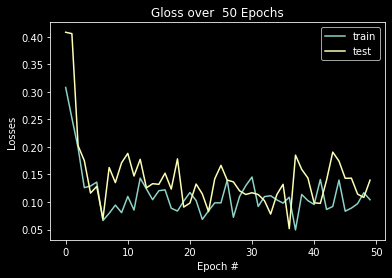

In [22]:
# initialize empty lists
gen_avg_train_losses = []
gen_avg_test_losses = []
dis_avg_train_losses = []
dis_avg_test_losses = []

# read "g_train_loss.txt"
with open("./losses/g_train_loss.txt", "r") as file:
    for line in file:
        gen_avg_train_losses.append(float(line.strip()))

# read "g_test_loss.txt"
with open("./losses/g_test_loss.txt", "r") as file:
    for line in file:
        gen_avg_test_losses.append(float(line.strip()))

# read "d_train_loss.txt"
with open("./losses/d_train_loss.txt", "r") as file:
    for line in file:
        dis_avg_train_losses.append(float(line.strip()))

# read "d_test_loss.txt"
with open("./losses/d_test_loss.txt", "r") as file:
    for line in file:
        dis_avg_test_losses.append(float(line.strip()))

# Plot Train losses
plt.plot(dis_avg_train_losses)
plt.plot(dis_avg_test_losses)
plt.title('Dloss over  50 Epochs')
plt.ylabel('Losses')
plt.xlabel('Epoch #')
plt.legend(['train','test'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(gen_avg_train_losses)
plt.plot(gen_avg_test_losses)
plt.title('Gloss over  50 Epochs')
plt.ylabel('Losses')
plt.xlabel('Epoch #')
plt.legend(['train','test'], loc='upper right')
plt.show()

## 8. Test

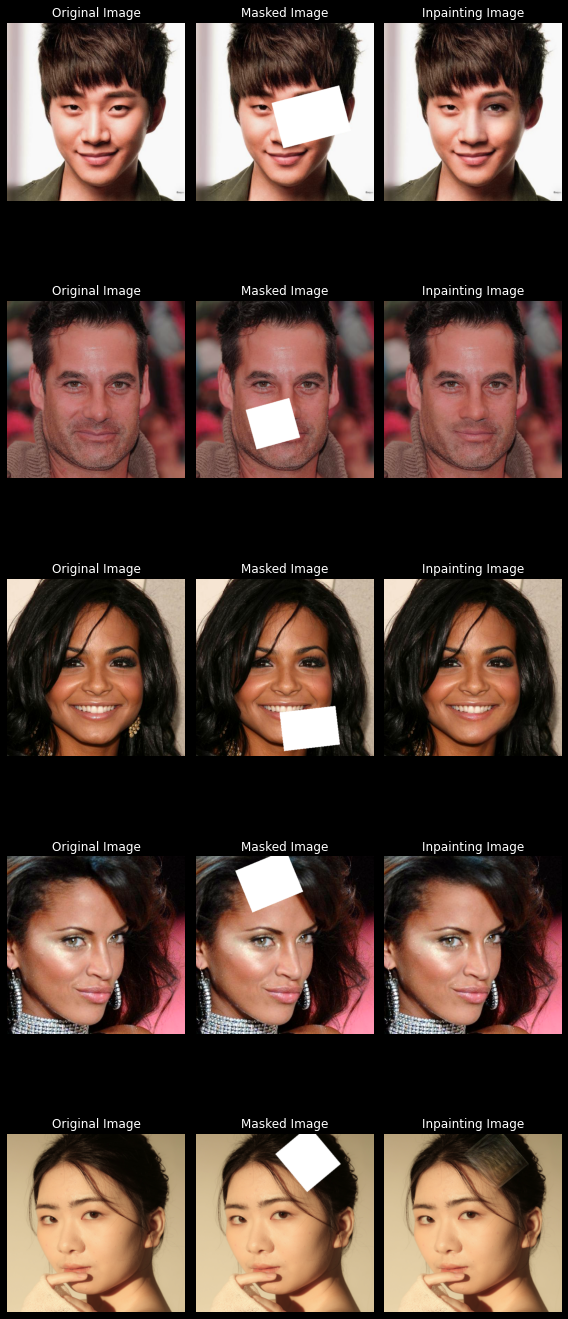

In [30]:
# You can play with our well-trained model in this cell
# put the testing images under 'images/test' and run this cell, set the image files end with .jpg
# the masks will be automatically generated

# Initialize the model
generator_test = Generator().to(device)
discriminator_test = Discriminator().to(device)
# load our well-trained model
generator_test.load_state_dict(torch.load("./models/generator.pt", map_location=device))
discriminator_test.load_state_dict(torch.load("./models/discriminator.pt", map_location=device))

# read the image files from the test directory
image_dir = './images/test/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

fig, axs = plt.subplots(len(image_files), 3, figsize=(8, len(image_files) * 4))

# Generate images for visualization of the result of the generator
with torch.no_grad():
    # display each image
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        # Read the image as a PIL image
        pil_image = Image.open(image_path)
        # create mask for the image
        mask = create_mask(pil_image)
        mask = mask_transform(mask)
        # Convert the PIL image to a tensor
        real_image = img_transform(pil_image)

        real_image = real_image.to(device)
        mask = mask.to(device)

        # create the image that has the mask
        image = (real_image * 2.0 - 1.0).unsqueeze(0)
        mask = mask.unsqueeze(0)
        image_masked = image * (1 - mask.float()) + mask

        # generate the image and fill the masked image will the generated image
        pred_img = generator_test(image_masked, mask)
        comp_img = (1 - mask) * image + mask * pred_img

        # Display the original image
        axs[idx, 0].imshow(postprocess(image[0]))
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title('Original Image')

        # Display the masked image
        axs[idx, 1].imshow(postprocess(image_masked[0]))
        axs[idx, 1].axis('off')
        axs[idx, 1].set_title('Masked Image')

        # Display the inpainting image
        axs[idx, 2].imshow(postprocess(comp_img[0]))
        axs[idx, 2].axis('off')
        axs[idx, 2].set_title('Inpainting Image')


    plt.tight_layout()
    plt.show()

#### The last image has 3840x4844 demonstration which differs from the images in the dataset. 

## 9. Conclusions

#### In this work, we have implemented an image inpainting model based on the Aggregated COntextual-Transformation GAN (AOT-GAN) for high-quality inpainting of celebrity images. The dataset used in our experiments consists of 30,000 celebrity images, with 80% designated for training and 20% for testing. All images are of size 512x512 pixels. Our model is trained with masks that are rectangular blocks with random sizes, positions, and angles. The training and testing losses converge after 10 epochs, although some fluctuations still occur.

#### There are some limitations to our current implementation. First, the masks used during training are rectangular blocks, whereas the original AOT-GAN paper utilized masks with random shapes. Training with random-shaped masks might yield even better results. Second, our model is trained and tested on 512x512 images, and it may not perform optimally on images with different resolutions, such as the 3840x4844 demonstration image. Additionally, the inpainting quality for side-view images or eye-masked image may not be as high. Third, our dataset only includes images with a single person, which limits the model's applicability to multi-person scenarios. Lastly, there is a bias in the training dataset as it lacks a sufficient number of images of Asian individuals. Consequently, the model may generate eye features with a more European appearance when inpainting Asian faces.

#### Despite these limitations, our work demonstrates the potential of AOT-GAN for high-quality image inpainting tasks. Future work could address the limitations by incorporating more diverse and complex masks during training, expanding the dataset to include images with multiple individuals, and improving the dataset's representation of different ethnicities. These improvements could potentially result in even better inpainting performance across various scenarios and image resolutions.

## 10. References

[1] Y. Zeng, (2021). Aggregated Contextual Transformations for
High-Resolution Image Inpainting. arXiv preprint arXiv:2104.01431. Retrieved from https://arxiv.org/pdf/2104.01431.pdf